# **Run the airGR (GR6J) lumped catchment hydrological model**

#UKCEH West Africa Hydrological Forecasting Training Workshop 2026

Katie Facer-Childs, Ezra Kitson, Eugene Magee, Adriana Calderon, Lucy Barker

(c) UKCEH 2026

This R code is an example of running the airGR model. It uses freely available data for the River Cree at Newton Stewart (ID: 81002) - and uses naturalised river flow data.

In [ ]:
#install packages
install.packages(c("airGR", "plotly",
                    "htmlwidgets"))

#load packages
library(plotly)
library(htmlwidgets)
library(airGR)
library(RColorBrewer)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘crosstalk’


Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




**Load some observed flow data**

In [ ]:
#Load data from Github
observed_data <- read.csv(
  "https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/Qobs_81002.csv")
#correct date format
observed_data$DATE <- strptime(observed_data$DATE, format = "%d/%m/%Y")

In [ ]:
class(observed_data)
ncol(observed_data)

[1] "data.frame"

[1] 2

In [ ]:
head(observed_data)

,DATE,Qobs
,<dttm>,<dbl>
1,1963-10-01,31.43
2,1963-10-02,32.00
3,1963-10-03,88.63
4,1963-10-04,46.72
5,1963-10-05,52.39
6,1963-10-06,23.53


**Make a quick plot to look at the observed data**

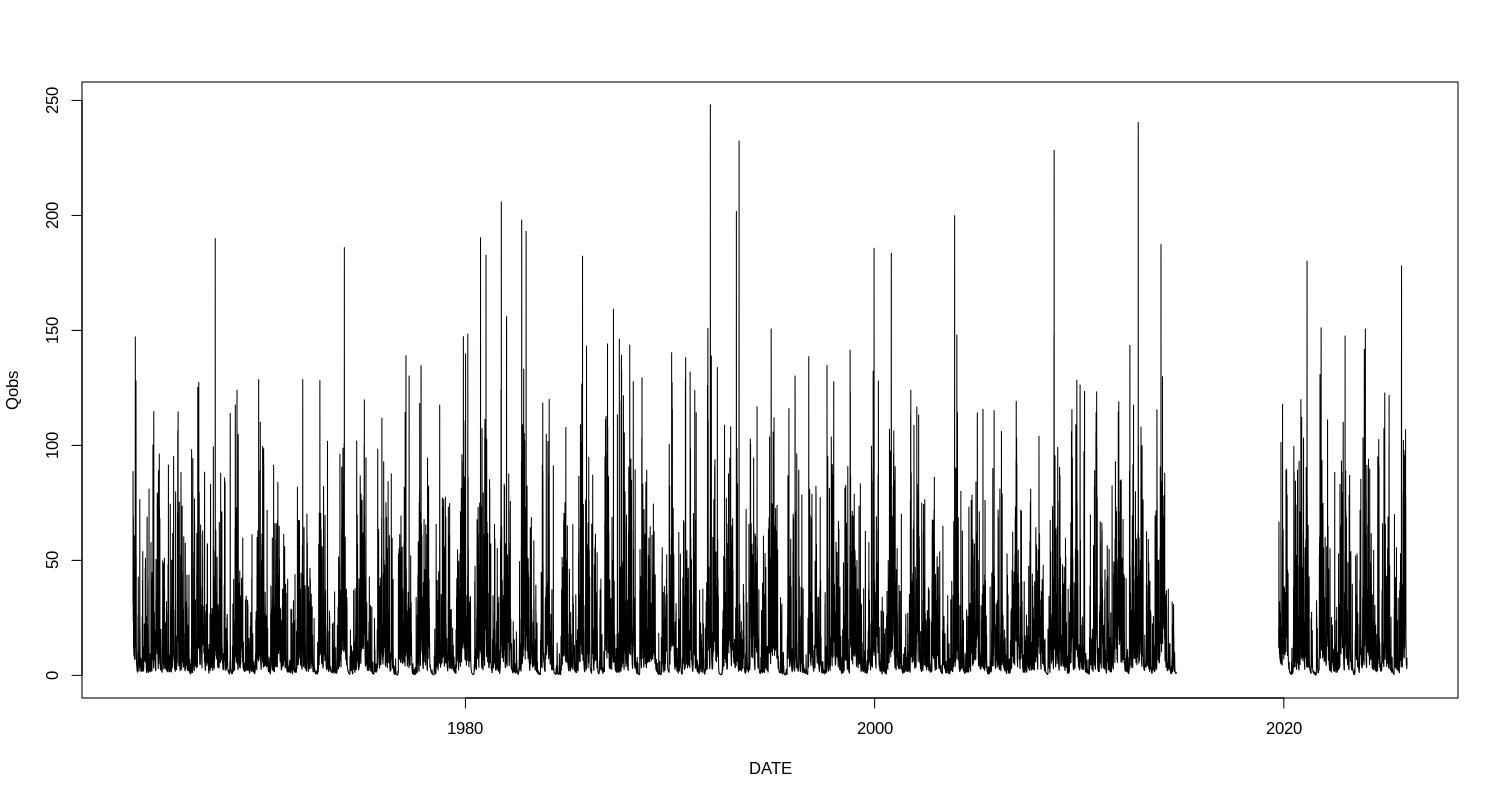

In [ ]:
#first set the dimensions of the plots in this notebook
options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 100)
#then plot
plot(observed_data,type="l")


**Zoom in to a smaller time-frame**

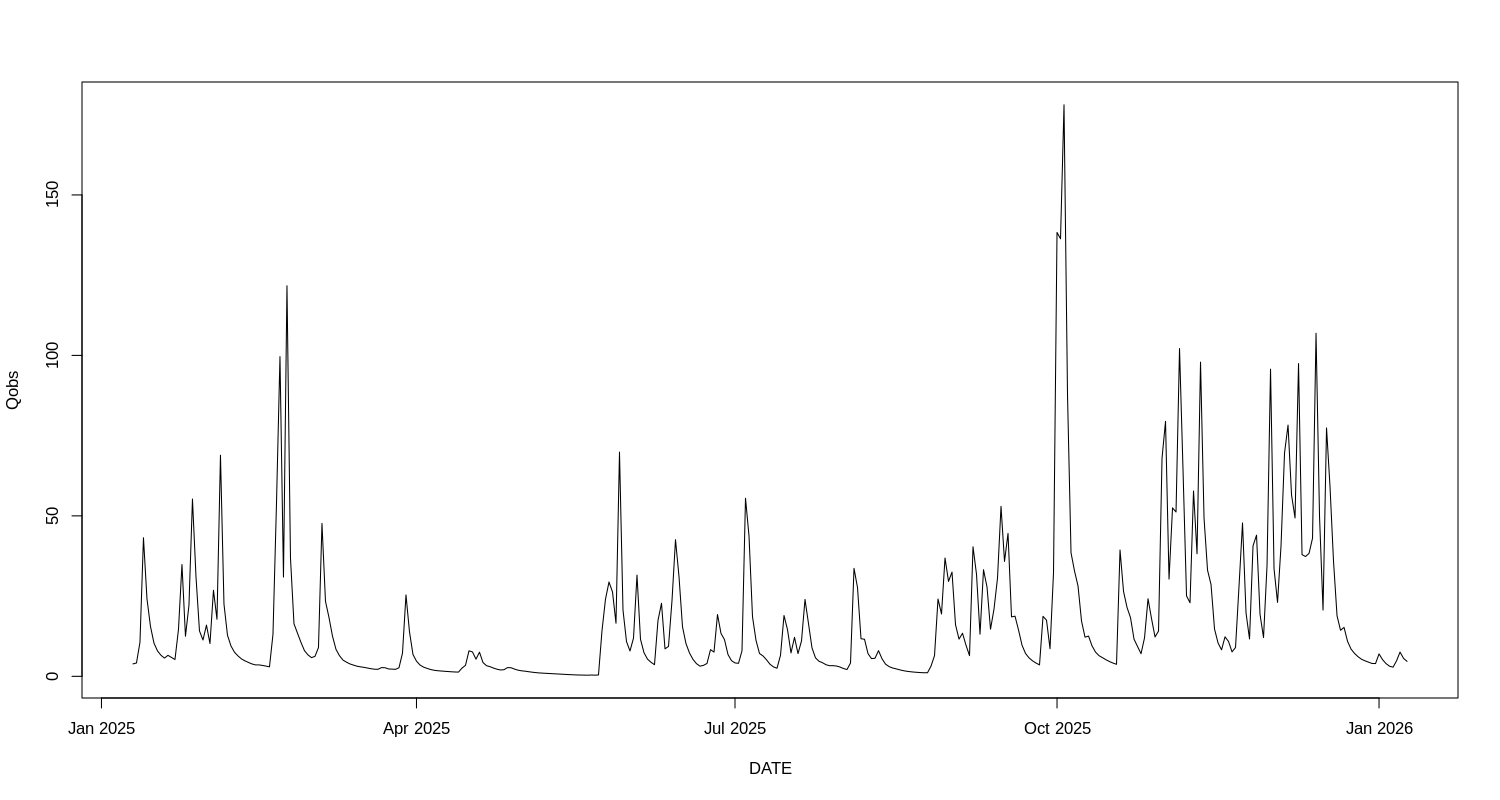

In [ ]:
plot(tail(observed_data,n=365),type="l")

**Load in observed precipitation and Potential Evapotranspiration (PET) data for the catchment (or basin)**

In [ ]:
precip_data<-read.csv("https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/rain_81002.csv")
PET_data<-read.csv("https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/PET_81002.csv")
#convert date format again
precip_data$DATE <- strptime(precip_data$DATE, "%Y-%m-%d")
PET_data$DATE <- strptime(PET_data$DATE, "%Y-%m-%d")

**Find a common time period between the precipitation and PET datasets**

In [ ]:
first_date <- max(observed_data$DATE[1], precip_data$DATE[1], PET_data$DATE[1])
last_date <- min(observed_data$DATE[length(observed_data$DATE)], precip_data$DATE[length(precip_data$DATE)], PET_data$DATE[length(PET_data$DATE)])

In [ ]:
first_date <- max(observed_data$DATE[1],
                  precip_data$DATE[1],
                  PET_data$DATE[1])

last_date  <- min(observed_data$DATE[length(observed_data$DATE)],
                  precip_data$DATE[length(precip_data$DATE)],
                  PET_data$DATE[length(PET_data$DATE)])

print(first_date)
print(last_date)

[1] "1963-10-01 UTC"
[1] "2023-12-31 UTC"


**Create a data frame of the right length for the observed flow, precipitation and PET data**


In [ ]:
#make an empty data frame
cree_data <- as.data.frame(matrix(NA,nrow=as.numeric((last_date-first_date)+1), ncol=4))
colnames(cree_data) <-c ("date","PET","precip","obs")
#make the date timeseries
cree_data$date <- seq(first_date, last_date, by="days")
#populate the data frame with the data
cree_data$obs <- observed_data$Qobs[which(observed_data$DATE==cree_data$date[1]):which(observed_data$DATE==cree_data$date[length(cree_data$date)])]
cree_data$precip <- precip_data$Mean_rainfall[which(precip_data$DATE==cree_data$date[1]):which(precip_data$DATE==cree_data$date[length(cree_data$date)])]
cree_data$PET <- PET_data$PET[which(PET_data$DATE==cree_data$date[1]):which(PET_data$DATE==cree_data$date[length(cree_data$date)])]
#convert the observed discharge to runoff (so its in the same units as the precip)
# divide by catchment area (m2) and mulitply by 86.4
cree_data$obs <- (cree_data$obs/368)*86.4

In [ ]:
tail(cree_data)

,date,PET,precip,obs
,<dttm>,<dbl>,<dbl>,<dbl>
22002,2023-12-26,0.1981631,28.775154,5.688783
22003,2023-12-27,0.2152607,26.529828,35.358261
22004,2023-12-28,0.2230708,7.029323,11.403391
22005,2023-12-29,0.2165183,9.177904,9.644870
22006,2023-12-30,0.1886552,23.140543,12.612522
22007,2023-12-31,0.2085451,16.642511,14.453217


# So, now let's do some modelling
Check this website for a good guide through the model:
https://hydrogr.github.io/airGR/

**Prepare the input data in the correct format**

In [ ]:
BasinObs <- cree_data
colnames(BasinObs) <- c('DatesR','E','P', 'Qobs')
head(BasinObs)

,DatesR,E,P,Qobs
,<dttm>,<dbl>,<dbl>,<dbl>
1,1963-10-01,0.9923856,6.093764,7.379217
2,1963-10-02,0.9161787,29.136598,7.513043
3,1963-10-03,0.9296119,4.453559,20.808783
4,1963-10-04,0.8572660,17.544664,10.969043
5,1963-10-05,0.8583078,3.818390,12.300261
6,1963-10-06,0.7863702,5.025787,5.524435


**Build Model Inputs for GR6J**

In [ ]:
# this defines which model we want to run, and defines the variables for the models input data
# note NA values of precip and PET are NOT ALLOWED
InputsModel <- CreateInputsModel(FUN_MOD = RunModel_GR6J,DatesR = BasinObs$DatesR,
                                 Precip = BasinObs$P,PotEvap = BasinObs$E)
str(InputsModel)

List of 3
 $ DatesR : POSIXlt[1:22007], format: "1963-10-01" "1963-10-02" ...
 $ Precip : num [1:22007] 6.09 29.14 4.45 17.54 3.82 ...
 $ PotEvap: num [1:22007] 0.992 0.916 0.93 0.857 0.858 ...
 - attr(*, "FeatFUN_MOD")=List of 11
  ..$ CodeMod     : chr "GR6J"
  ..$ NameMod     : chr "GR6J"
  ..$ NbParam     : int 6
  ..$ TimeUnit    : chr "daily"
  ..$ Id          : logi NA
  ..$ Class       : chr [1:2] "daily" "GR"
  ..$ Pkg         : chr "airGR"
  ..$ NameFunMod  : chr "RunModel_GR6J"
  ..$ TimeStep    : num 86400
  ..$ TimeStepMean: int 86400
  ..$ CodeModHydro: chr "GR6J"
 - attr(*, "class")= chr [1:3] "InputsModel" "daily" "GR"


**Define Run options**

Experiment by changing the simulation period and comparing how the results differ.

In [ ]:
#define simulation period
Ind_Run <- seq(which(BasinObs$DatesR=="1981-01-01"),
               which(BasinObs$DatesR=="2023-12-31"))
RunOptions <- suppressWarnings(
  CreateRunOptions(
    FUN_MOD = RunModel_GR6J,
    InputsModel = InputsModel,
    IndPeriod_Run = Ind_Run,
    IndPeriod_WarmUp = NULL
  )
)
#print what the RunOptions look like
str(RunOptions)

List of 8
 $ IndPeriod_WarmUp: int [1:366] 5937 5938 5939 5940 5941 5942 5943 5944 5945 5946 ...
 $ IndPeriod_Run   : int [1:15705] 6303 6304 6305 6306 6307 6308 6309 6310 6311 6312 ...
 $ IniStates       : Named num [1:71] 350 90 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "names")= chr [1:71] "Store.Prod" "Store.Rout" "Store.Exp" "Store.Int" ...
 $ IniResLevels    : num [1:4] 0.3 0.5 0 NA
 $ Outputs_Cal     : chr [1:2] "Qsim" "Param"
 $ Outputs_Sim     : Named chr [1:24] "DatesR" "PotEvap" "Precip" "Prod" ...
  ..- attr(*, "names")= chr [1:24] "" "GR1" "GR2" "GR3" ...
 $ FortranOutputs  :List of 2
  ..$ GR: chr [1:20] "PotEvap" "Precip" "Prod" "Pn" ...
  ..$ CN: NULL
 $ FeatFUN_MOD     :List of 12
  ..$ CodeMod     : chr "GR6J"
  ..$ NameMod     : chr "GR6J"
  ..$ NbParam     : int 6
  ..$ TimeUnit    : chr "daily"
  ..$ Id          : logi NA
  ..$ Class       : chr [1:2] "daily" "GR"
  ..$ Pkg         : chr "airGR"
  ..$ NameFunMod  : chr "RunModel_GR6J"
  ..$ TimeStep    : num 86400
  ..$ Ti

**Create the InputsCrit object - define the model performance (or 'error') metric -- you can choose from RMSE, NSE, KGE or modified KGE (KGE2)**

In [ ]:
InputsCrit <- CreateInputsCrit(FUN_CRIT = ErrorCrit_NSE,
                               InputsModel = InputsModel,
                               RunOptions = RunOptions,
                               Obs = BasinObs$Qobs[Ind_Run])
str(InputsCrit)


List of 8
 $ FUN_CRIT:function (InputsCrit, OutputsModel, warnings = TRUE, verbose = TRUE)  
  ..- attr(*, "class")= chr [1:2] "FUN_CRIT" "function"
 $ Obs     : num [1:15705] 7.8 42.89 16.23 5.01 3.47 ...
 $ VarObs  : chr "Q"
 $ BoolCrit: logi [1:15705] TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ idLayer : logi NA
 $ transfo : chr ""
 $ epsilon : NULL
 $ Weights : NULL
 - attr(*, "class")= chr [1:2] "Single" "InputsCrit"


**Set the calibration option to the default GR6J calibration algorithm**


In [ ]:
CalibOptions <- CreateCalibOptions(FUN_MOD = RunModel_GR6J,
                                   FUN_CALIB = Calibration_Michel)
str(CalibOptions)

List of 4
 $ FixedParam       : logi [1:6] NA NA NA NA NA NA
 $ SearchRanges     : num [1:2, 1:6] 4.59e-05 2.18e+04 -1.09e+04 1.09e+04 4.59e-05 ...
 $ FUN_TRANSFO      :function (ParamIn, Direction)  
 $ StartParamDistrib: num [1:3, 1:6] 36.598 49.402 90.017 -1.175 -0.521 ...
 - attr(*, "class")= chr [1:4] "CalibOptions" "daily" "GR" "HBAN"


**Run the calibration**

In [ ]:
OutputsCalib <- Calibration_Michel(InputsModel = InputsModel,
                                   RunOptions = RunOptions,
                                   InputsCrit = InputsCrit,
                                   CalibOptions = CalibOptions,
                                   FUN_MOD = RunModel_GR6J,
                                   FUN_CRIT = ErrorCrit_NSE)

Warning message in Calibration_Michel(InputsModel = InputsModel, RunOptions = RunOptions, :
“argument 'FUN_CRIT' is deprecated. The error criterion function is now automatically get from the 'InputsCrit' object”
Grid-Screening in progress (
0%
 20%
 40%
 60%
 80%
 100%)

	 Screening completed (729 runs)

	     Param =   36.598,   -0.521,   27.113,    1.369,    0.220,   20.086

	     Crit. NSE[Q]       = 0.7827

Steepest-descent local search in progress

	 Calibration completed (74 iterations, 1609 runs)

	     Param =   13.183,   -1.284,   12.905,    1.337,    0.627,    6.963

	     Crit. NSE[Q]       = 0.8497



NSE = 0.8497 - not bad!!

**Define the parameters found by the calibration routine**


In [ ]:
Param <- OutputsCalib$ParamFinalR
Param


[1] 13.1827523 -1.2840980 12.9047574  1.3369564  0.6269071  6.9627714

## RUN THE MODEL

In [ ]:
OutputsModel <- RunModel_GR6J(InputsModel = InputsModel,
                              RunOptions = RunOptions,
                              Param= Param)
str(OutputsModel)

List of 23
 $ DatesR    : POSIXlt[1:15705], format: "1981-01-01" "1981-01-02" ...
 $ PotEvap   : num [1:15705] 0.215 0.235 0.223 0.178 0.174 ...
 $ Precip    : num [1:15705] 26.5899 30.6338 3.2779 0.0467 7.2343 ...
 $ Prod      : num [1:15705] 13.1 13.1 13 12.7 12.9 ...
 $ Pn        : num [1:15705] 26.37 30.4 3.05 0 7.06 ...
 $ Ps        : num [1:15705] 0.1566 0.1271 0.0469 0 0.2901 ...
 $ AE        : num [1:15705] 0.215 0.235 0.223 0.178 0.174 ...
 $ Perc      : num [1:15705] 0.125 0.125 0.122 0.111 0.119 ...
 $ PR        : num [1:15705] 26.344 30.398 3.129 0.111 6.888 ...
 $ Q9        : num [1:15705] 16.54 25.47 15.48 1.5 3.05 ...
 $ Q1        : num [1:15705] 1.466 2.593 2.344 0.486 0.202 ...
 $ Rout      : num [1:15705] 12.5 12.7 12.5 10.9 10.6 ...
 $ Exch      : num [1:15705] -0.383 -0.44 -0.464 -0.441 -0.278 ...
 $ AExch1    : num [1:15705] -0.383 -0.44 -0.464 -0.441 -0.278 ...
 $ AExch2    : num [1:15705] -0.383 -0.44 -0.464 -0.441 -0.202 ...
 $ AExch     : num [1:15705] -1.149 -

**Use the inbuilt plot function to look at the results**

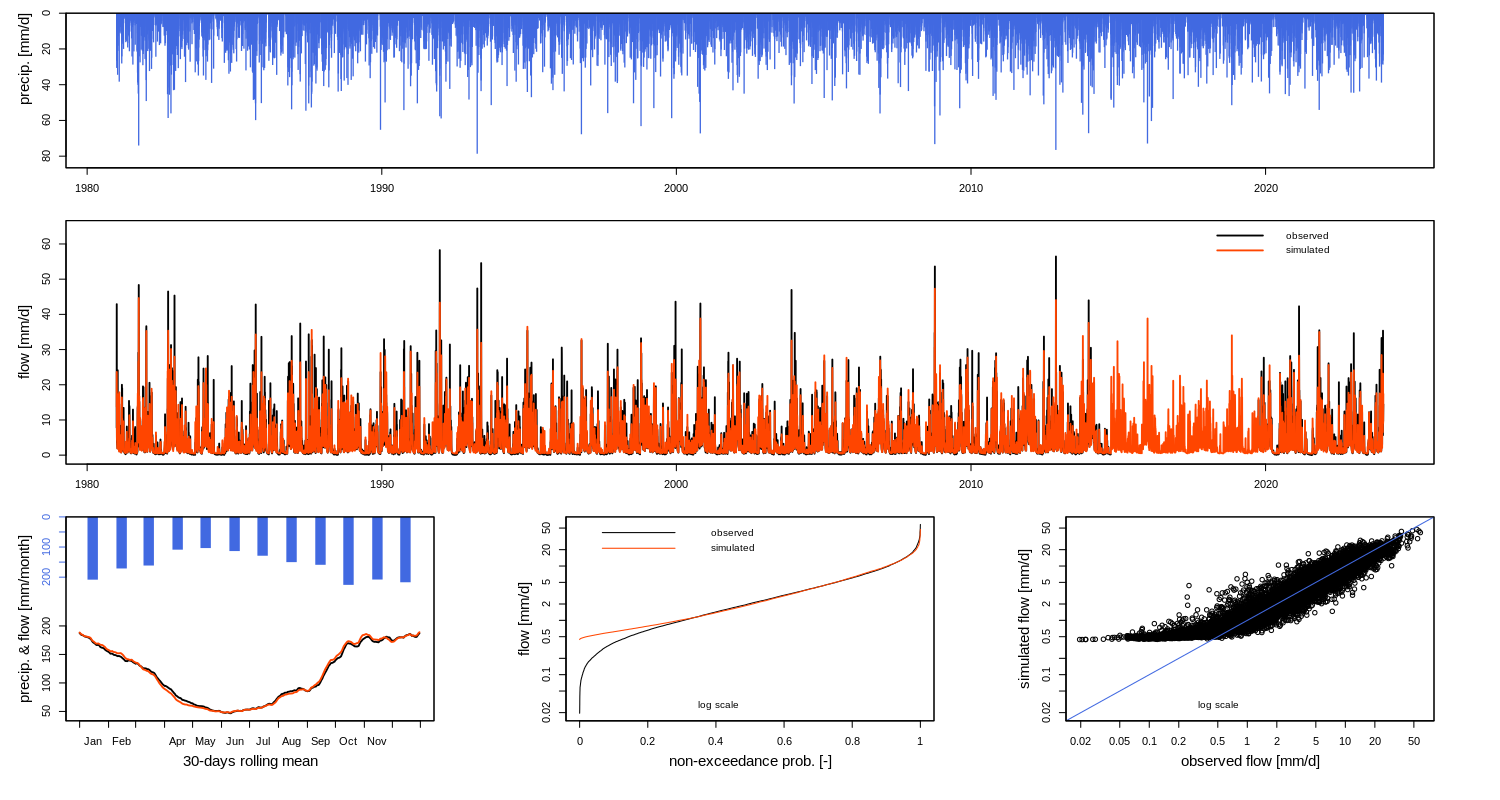

In [ ]:
plot(OutputsModel, Qobs=BasinObs$Qobs[Ind_Run])

In [ ]:
class(OutputsModel$DatesR)

[1] "POSIXlt" "POSIXt"

Looking good - but we've got some discrepancy at the low flows end.

*Look at the non-exceedance probabilty plot, in the middle of the bottom row.*

NSE is well known for this, it is based on the square of the flows, so over-weights the calibration to the high flows.

I wonder if the modified KGE can do any better?

**Tweak the calibration criteria**

Grid-Screening in progress (
0%
 20%
 40%
 60%
 80%
 100%)

	 Screening completed (729 runs)

	     Param =   36.598,   -0.521,   27.113,    1.369,    0.220,   20.086

	     Crit. KGE2[Q]      = 0.8002

Steepest-descent local search in progress

	 Calibration completed (90 iterations, 1811 runs)

	     Param =   33.801,   -1.043,   31.287,    1.361,    0.556,    0.878

	     Crit. KGE2[Q]      = 0.9216



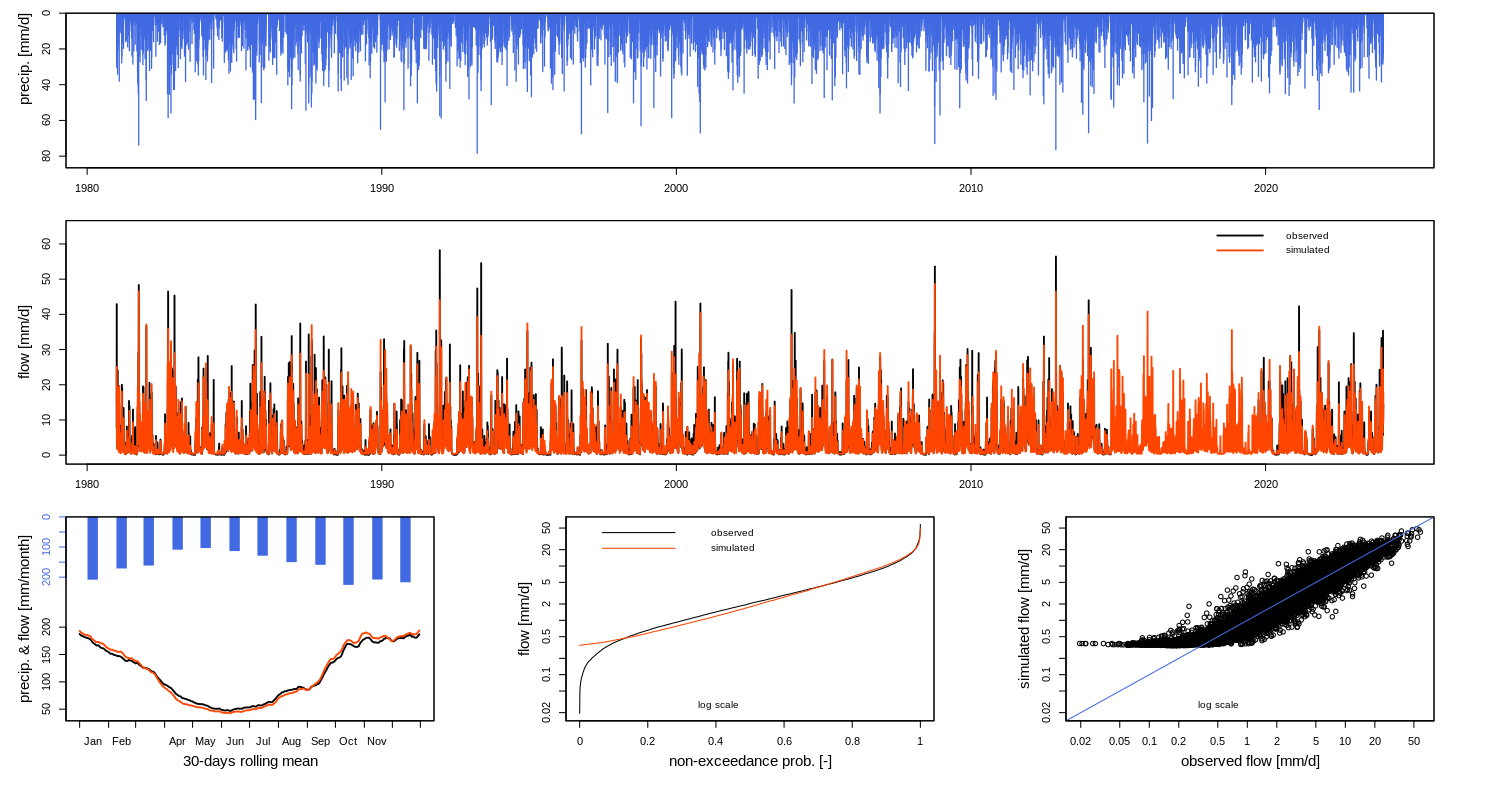

In [ ]:
# make a few changes to the calibration criteria
InputsCrit <- CreateInputsCrit(FUN_CRIT = ErrorCrit_KGE2,
                               InputsModel = InputsModel,
                               RunOptions = RunOptions,
                               Obs = BasinObs$Qobs[Ind_Run])
# rerun the calibration
OutputsCalib <- Calibration_Michel(InputsModel = InputsModel,
                                   RunOptions = RunOptions,
                                   InputsCrit = InputsCrit,
                                   CalibOptions = CalibOptions,
                                   FUN_MOD = RunModel_GR6J)#,
                                   #FUN_CRIT = ErrorCrit_KGE2)

# redefine the parameters
Param <- OutputsCalib$ParamFinalR
# rerun the model
OutputsModel <- RunModel_GR6J(InputsModel = InputsModel,
                              RunOptions = RunOptions,
                              Param= Param)
# plot again
plot(OutputsModel, Qobs=BasinObs$Qobs[Ind_Run])

# not much different. Oh well, we can be happy with either of those metric scores.
# - pause for thought - which parameter set would you choose to use?!

It still does not look very good. The model appears to struggle with low flows in this mountainous basin, even though the KGE2 score looks good.

## Let's do some validation

 Go back to the beginning, redefine the period to run on - Have a go at changing the period and compare how results differ

In [ ]:
# (the period we haven't used for calibration(the period before simulation starts), minus the first year needed for warm up)
Ind_Run <- seq(which(BasinObs$DatesR=="1963-10-01"),
               which(BasinObs$DatesR=="1980-12-31"))
RunOptions <- CreateRunOptions(FUN_MOD = RunModel_GR6J,
                               InputsModel = InputsModel,
                               IndPeriod_Run = Ind_Run,
                               IndPeriod_WarmUp = NULL)

InputsCrit <- CreateInputsCrit(FUN_CRIT = ErrorCrit_KGE2,
                               InputsModel = InputsModel,
                               RunOptions = RunOptions,
                               Obs = BasinObs$Qobs[Ind_Run])
Param <- OutputsCalib$ParamFinalR
OutputsModel <- RunModel_GR6J(InputsModel = InputsModel,
                              RunOptions = RunOptions,
                              Param= Param)
OutputsCrit <- ErrorCrit_KGE2(InputsCrit = InputsCrit,
                              OutputsModel = OutputsModel)

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up period is used

Warning message in CreateRunOptions(FUN_MOD = RunModel_GR6J, InputsModel = InputsModel, :
“model warm up period not defined: default configuration used
 no data were found for model warm up!”
Warning message in CreateIniStates(FUN_MOD = FUN_MOD, InputsModel = InputsModel, :
“'RunModel_GR6J' does not require 'IntStore'. Values set to NA”
Warning message in CreateIniStates(FUN_MOD = FUN_MOD, InputsModel = InputsModel, :
“'RunModel_GR6J' does not require 'GCemaNeigeLayers' 'GCemaNeigeLayers', 'GthrCemaNeigeLayers' and 'GlocmaxCemaNeigeLayers'. Values set to NA”
Crit. KGE2[Q] = 0.8789

	SubCrit. KGE2[Q] cor(sim, obs, "pearson") = 0.8961 
	SubCrit. KGE2[Q] cv(sim)/cv(obs)          = 1.0190 
	SubCrit. KGE2[Q] mean(sim)/mean(obs)      = 0.9408 




Slightly worse than the calibration period (KGE=0.8789) but not bad at all.

**Finally, lets run the model for the whole time period**

In [ ]:

Ind_Run <- seq(which(BasinObs$DatesR=="1964-01-01"),
               which(BasinObs$DatesR=="2023-12-31"))
RunOptions <- CreateRunOptions(FUN_MOD = RunModel_GR6J,
                               InputsModel = InputsModel,
                               IndPeriod_Run = Ind_Run,
                               IndPeriod_WarmUp = NULL)

Param <- OutputsCalib$ParamFinalR
OutputsModel <- RunModel_GR6J(InputsModel = InputsModel,
                              RunOptions = RunOptions,
                              Param= Param)

Warning message in CreateRunOptions(FUN_MOD = RunModel_GR6J, InputsModel = InputsModel, :
“model warm up period not defined: default configuration used
  less than a year (without missing values) was found for model warm up:
  (92 time-steps are used for initialisation)”
Warning message in CreateIniStates(FUN_MOD = FUN_MOD, InputsModel = InputsModel, :
“'RunModel_GR6J' does not require 'IntStore'. Values set to NA”
Warning message in CreateIniStates(FUN_MOD = FUN_MOD, InputsModel = InputsModel, :
“'RunModel_GR6J' does not require 'GCemaNeigeLayers' 'GCemaNeigeLayers', 'GthrCemaNeigeLayers' and 'GlocmaxCemaNeigeLayers'. Values set to NA”


We can explore things a bit more with the airGR teaching package: open this browser page and explore what happens when you change parameter values etc. https://sunshine.inrae.fr/app/airGRteaching

**Build an interactive plot of observed vs simulated flow using plotly**

 Save the interactive figure as an HTML file. You’ll find it in the Files panel (left sidebar). Download it and open it in a web browser to zoom, pan, and hover for values.

In [ ]:
#convert model output dates for plotting in plotly
x_dates <- as.POSIXct(OutputsModel$DatesR)

#create interactive plot
p <- plot_ly() %>%
  add_lines(x = x_dates, y = BasinObs$Qobs[Ind_Run], name = 'Observed') %>%
  add_lines(x = x_dates, y = OutputsModel$Qsim,        name = 'Simulated') %>%
  layout(title = 'Observed vs Simulated Flow',
         xaxis = list(title = ''),
         yaxis = list(title = 'Flow (mm/day)'))

#save plot as an html file (download from Files left pane)
htmlwidgets::saveWidget(p, 'plotly_flow.html', selfcontained = TRUE)


# Next we'll use the GR6J model to run an ESP forecast with the "2. Run ESP" Notebook